In [1]:
import transformer_lens
from datasets import load_dataset
import torch
import matplotlib.pyplot as plt
import pandas as pd
import torch.nn as nn
from sklearn.decomposition import PCA
import numpy as np

import torch.nn.functional as F

from tqdm import tqdm
from scipy.stats import spearmanr

import random

In [2]:
torch.manual_seed(42)
random.seed(42)
np.random.seed(42)

In [3]:
# Load datasets
train_set = load_dataset("sentence-transformers/stsb", split="train")
test_set  = load_dataset("sentence-transformers/stsb", split="test")

first_train  = torch.load('gpt2_medium_train_acts_1.npy')
second_train = torch.load('gpt2_medium_train_acts_2.npy')

first_test = torch.load('gpt2_medium_test_acts_1.npy')
second_test = torch.load('gpt2_medium_test_acts_2.npy')

train_scores = torch.Tensor(train_set['score'])
test_scores = torch.Tensor(test_set['score'])

In [4]:
# Calculate layerwise cosine distance
def calculate_cosine_distance(first, second):
    cos = torch.nn.functional.cosine_similarity
    
    sims = []
    bn, n_layers, d_model = first.shape
    
    for f, s in zip(first, second):
        sims.append(cos(f,s))

    sims_t = torch.stack(sims)
    return (sims_t - sims_t.mean()) / sims_t.std()

train_cosines = calculate_cosine_distance(first_train, second_train)
test_cosines = calculate_cosine_distance(first_test, second_test)

Text(0, 0.5, 'Correlation')

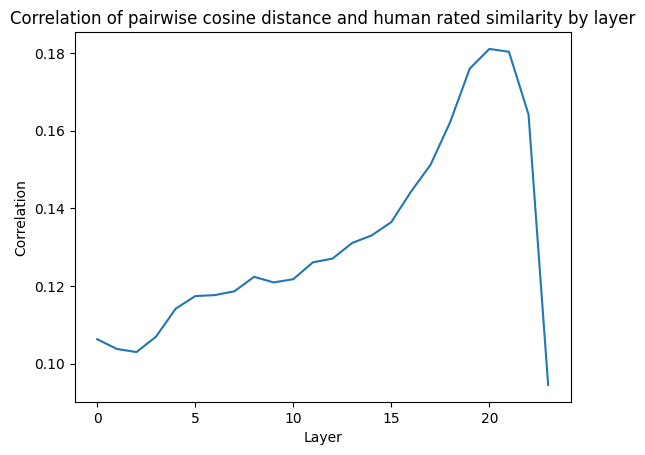

In [5]:
# For each layer, compute the correlation between the cosines of the train set. We don't have to bother checking the test set
# because we're not doing any learning and we assume theyre from the same distribution.

corrs = []
for i in range(24):
    # Cosines at the layer for every item in the batch
    cosines = train_cosines[:, i]

    # Calculate correlation with human score
    corr = torch.corrcoef(torch.stack([cosines, train_scores]))[1, 0]

    corrs.append(corr)

plt.plot(corrs)
plt.title("Correlation of pairwise cosine distance and human rated similarity by layer")
plt.xlabel("Layer")
plt.ylabel("Correlation")

In [7]:
# Obvious simple model
class CosineWeighter(nn.Module):
    def __init__(self, n_layers=24, d_hidden=128):
        super().__init__()
        self.fc1 = nn.Linear(n_layers, d_hidden)
        self.out = nn.Linear(d_hidden, 1)

    def forward(self, x):
        h = F.relu(self.fc1(x))
        h = F.sigmoid(self.out(h))
        
        return h.squeeze()

cw = CosineWeighter().to('cuda:0')

optimizer = torch.optim.AdamW(cw.parameters(), lr=3e-4)
loss_fn = torch.nn.MSELoss()

def epoch(model, sim_data, scores, batch_size=32):
    model.train()

    n_batches = sim_data.shape[0] // batch_size

    for batch in range(n_batches):
        data_batch   = sim_data[batch*batch_size: (batch+1) * batch_size].to('cuda:0')
        scores_batch = torch.Tensor(scores[batch*batch_size: (batch+1) * batch_size]).to('cuda:0')

        optimizer.zero_grad()

        outputs = model(data_batch)
        loss = loss_fn(outputs, scores_batch)

        loss.backward()

        optimizer.step()

    return loss.item()

# Train obvious simple model
for _ in tqdm(range(100)):
    epoch(cw, train_cosines, train_scores)

print(torch.corrcoef(torch.stack([cw.to('cpu')(test_cosines), test_scores])))
print(spearmanr(cw.to('cpu')(test_cosines).detach().numpy(), test_scores))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:11<00:00,  8.86it/s]

tensor([[1.0000, 0.3926],
        [0.3926, 1.0000]], grad_fn=<ClampBackward1>)
SignificanceResult(statistic=0.42066978283469764, pvalue=2.973071370511246e-60)
